Accuracy: 87.23%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88      1290
         1.0       0.88      0.86      0.87      1270

    accuracy                           0.87      2560
   macro avg       0.87      0.87      0.87      2560
weighted avg       0.87      0.87      0.87      2560



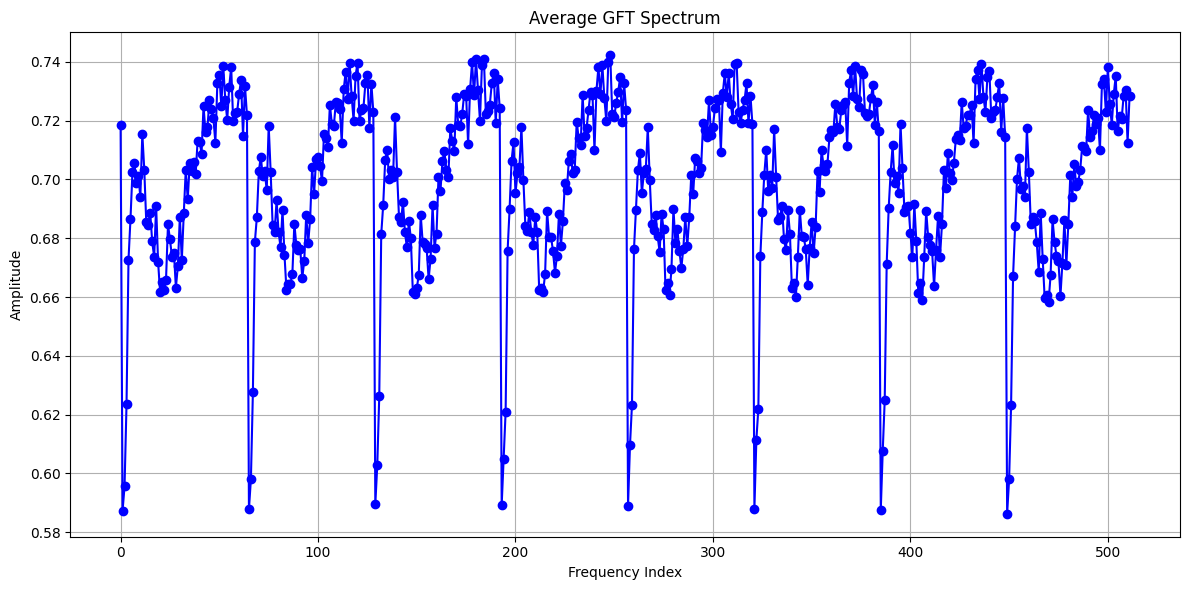

Feature extraction and SVM classification completed.


In [1]:
import scipy.io as sio
import numpy as np
from pygsp import graphs
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch

# ----------- Filtering Functions -----------

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyq = 0.5 * fs
    freq = notch_freq / nyq
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

# ----------- Load EEG Data -----------

try:
    data = sio.loadmat(r"D:\ASU\Long_words\sub_2b_ch64_l_eog_removed_256Hz.mat")
except FileNotFoundError:
    print("Error: File not found. Please check the path.")
    exit()

try:
    variable = data["eeg_data_wrt_task_rep_no_eog_256Hz_end_trial"]
except KeyError as e:
    print(f"Error: {e} not found. Check variable names in the .mat file.")
    exit()

fs = 256  # Sampling rate
all_features = []
labels = []

# ----------- Feature Extraction Loop -----------

for class_idx in range(2):  # 2 classes
    for trial_idx in range(100):  # 100 trials each
        matrix_data = variable[class_idx, trial_idx]  # (64, 512)

        # Apply filters channel-wise
        filtered_data = np.zeros_like(matrix_data)
        for ch in range(matrix_data.shape[0]):
            notch = notch_filter(matrix_data[ch, :], notch_freq=60, fs=fs)
            bandpassed = bandpass_filter(notch, lowcut=0.5, highcut=50, fs=fs)
            filtered_data[ch, :] = bandpassed

        # Compute correlation and GFT
        correlation_matrix = np.corrcoef(filtered_data)
        np.fill_diagonal(correlation_matrix, 0)
        G = graphs.Graph(correlation_matrix)
        G.compute_laplacian(lap_type='combinatorial')

        try:
            G.compute_fourier_basis()
        except AssertionError:
            G._e, G._U = np.linalg.eigh(G.L.toarray())
            G._e[0] = 0

        gft_signals = np.array([G.gft(filtered_data[:, i]) for i in range(filtered_data.shape[1])])
        all_features.append(gft_signals)
        labels.append(class_idx)

# ----------- Prepare Data for Classification -----------

all_features = np.array(all_features)  # (200, 64, 512)
labels = np.array(labels)

# Reshape to 2D (samples x features)
all_features_reshaped = all_features.reshape(-1, 512)  # (200*64, 512)

# Select 6400 samples per class (64 ch x 100 trials = 6400)
num_samples_per_class = 6400
features_class_0 = all_features_reshaped[:num_samples_per_class]
features_class_1 = all_features_reshaped[num_samples_per_class:num_samples_per_class*2]

selected_features = np.vstack((features_class_0, features_class_1))
labels = np.hstack((np.zeros(num_samples_per_class), np.ones(num_samples_per_class)))

# ----------- Standardization and Train/Test Split -----------

scaler = StandardScaler()
selected_features = scaler.fit_transform(selected_features)

X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=42)

# ----------- Train SVM Classifier -----------

svm = SVC(kernel='rbf', C=100, gamma=0.001)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# ----------- Evaluate Performance -----------

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ----------- Plot Average GFT Spectrum -----------

mean_gft_signal = np.mean(np.abs(selected_features), axis=0)

plt.figure(figsize=(12, 6))
plt.plot(mean_gft_signal, 'o-', color='blue')
plt.title('Average GFT Spectrum')
plt.xlabel('Frequency Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Feature extraction and SVM classification completed.")
